# Présentation du dataset
Ce dataset provient de l'Open Access Series of Imaging Studies (OASIS), un projet visant à mettre à disposition gratuitement des ensembles de données IRM du cerveau à la communauté scientifique.

Le fichier csv `oasis_long` contient des données longitudinales organisées comme suit: 
- 150 patients adultes agés entre 60 et 96 ans
- Chaque patient a été examiné deux fois ou plus (*Chaque patient apparaît donc au moins deux fois dans le dataset*). 
- Tous les sujets sont droitiers
- Les sujets comprennent à la fois des hommes et des femmes 
- 72 patients ont été caractérisés comme non déments tout au long de l'étude. 
- 64 sujets ont été caractérisés comme déments au moment de leur visite initiale et le sont restés tout au long de l'étude. 
- 14 sujets ont été caractérisés comme non déments au moment de leur visite initiale et le sont devenus par la suite (*correspondent à la classe `converted` dans la colonne `Group`*).

> Des **données longitudinales** sont des données qui prennent en compte l'évolution des valeurs dans le temps, contrairement à la validation croisée qui est un cliché statistique à un instant T. C'est la raison pour laquelle chaque sujet de ce dataset apparaît plusieurs fois, plus précisment à chaque examen.

# Importation des modules

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Exploration et arrangement des données

In [220]:
# Création du dataframe à partir du fichier csv
data = pd.read_csv('oasis_long.csv')

In [221]:
# Dimensions du dataset
# 373 lignes et 15 colonnes
data.shape

(373, 15)

In [222]:
# Affichage des 5 premières lignes
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


Nous voyons que les sujets `OAS2_0001` et `OAS2_0002`, identifiés par la variable `Subject ID`, apparaîssent plusieurs fois.

In [223]:
# Informations sur les données sur dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [224]:
# Quantification des données manquantes
data.isna().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

Les données semblement relativement intègres, elles ne présentent que peu de données manquantes :
- 19 données manquantes pour la colonne SES
- 2 données manquantes pour la colonne MMSE

## Suppression de la colonne `Hand`
Du fait que tous les patients présents dans ce dataset soient droitiers, il n'est pas pertinent de garder cette colonne. Nous allons donc la supprimer. 

In [225]:
# Supression de la colonne 'Hand'
data = data.drop(['Hand'], axis=1)

## Renommage des colonnes

Pour des raisons de commodité nous allons renommer les colonnes afin de pouvoir y faire référence plus facilement par la suite.

In [226]:
data.rename(columns= {"Subject ID" : "subject_id",
                      "MRI ID" : "MRI_id",
                      "Group" : "group",
                      "Visit" : "visit",
                      "MR Delay" : "MR_delay",
                      "M/F" : "genre",
                      "Age" : "age",
                      "EDUC" : "educ"},
            inplace = True)

## Explication des colonnes

- **genre**

F = Female
M = Male

- **age**

Age du patient

- **educ**

Niveau d'éducation du patient
  - 1 = less than high school grad 
  - 2 = high school grad 
  - 3 = some college 
  - 4 = college grad 
  - 5 = beyond college

- **SES**

*SocioEconomic Status*
  - 1 = Très bas
  - 2 = Bas
  - 3 = Moyen
  - 4 = Haut
  - 5 = Très haut

- **MMSE**

*Mini Mental State Examination*
Evaluation rapide de l'état cognitif du patient
(orientation dans le temps et l'espace, attention, mémoire, 
langage)
  - += 27 = Atteinte nulle
  - 21-26 = Atteinte légère
  - 11-20 = Atteinte modérée
  - <=10 = Atteinte sévère

- **CDR**

*Clinical Dementia Rating*
Evaluation des déficits cognitifs avec une perspective plus 
globales. Questionnaire sur 6 axes (mémoire, orientation,
jugement, langage, activité vie quotidienne, 
vie quotidienne instrumentale)
- 0 = Absence de trouble
- 0.5 = Troubles incertaines
- 1 = Troubles bénins
- 2 = Troubles modérés
- 3 = Troubles sévères

- **eTIV**

*Estimated Total Intracranial Volume*
Volume total du crâne qui contient le cerveau, le LCR et 
les méninges

- **nWBV**

*Normalize Whole Brain Volume*
Mesure qui permet de standardiser le volume total du cerveau 
d'un individu en le rapportant à une référence, 
généralement l'eTIV. En d'autres termes, le nWBV exprime le 
volume cérébral en rapport du volume total du crâne (eTIV)

- **ASF**

*Atlas Scaling Factor*
Facteur utilisé dans la recherche en neuroimagerie pour 
normaliser les mesures cérébrales entre les individus 
tout en tenant compte des différences de taille et de forme de 
la tête. Il garantit la cohérence des comparaisons et des 
analyses, en particulier dans les études sur la prédiction 
et la recherche concernant la maladie d'Alzheimer

# Création d'un nouveau dataset alternatif

Afin de faciliter certaines visualisations, nous allons créer un dataset alternatif composé de données croisées en non plus longitudinales, pour cela, nous n'allons garder que la dernière ligne de chaque sujet, correspondant à son dernier examen en date.

Pour cela nous allons procéder en trois étapes : 
- Tout d'abord nous filtreront le dataframe `data` par **ordre décroissant** des valeurs de la colonne `Visit` (*qui correspondent au nombre de visites effectuées par le patient*). Ainsi chaque première entrée d'un patient sera sa dernière visite en date.
- Ennsuite, nous utiliseront la fonction `drop_suplicates` sur la colonne `Subject ID` pour y supprimer tous les doublons : seuls les premières occurences seront gardées.
- Enfin, nous rétabliront l'ordre alphabétique sur la colonne `Subject ID`

> Nous nommeront ce nouveau dataset `data_u` pour souligner que chaque sujet y est **u**nique

In [227]:
# Classement par ordre décroissant des valeurs de 'Visit'
data_u = data.sort_values('visit', ascending=False)

# Suppression des doublons sur la colonne 'Subject ID'
data_u = data_u.drop_duplicates('subject_id')

# Retour à un classement alphabétiqu par 'Subject ID'
data_u = data_u.sort_values('subject_id')

In [228]:
data_u.head()

,subject_id,MRI_id,group,visit,MR_delay,genre,age,educ,SES,MMSE,CDR,eTIV,nWBV,ASF
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,80,12,NaN,22.0,0.5,1698,0.701,1.034
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,90,18,3.0,27.0,0.0,1200,0.718,1.462
9,OAS2_0005,OAS2_0005_MR3,Nondemented,3,1603,M,85,12,4.0,30.0,0.0,1699,0.705,1.033
12,OAS2_0007,OAS2_0007_MR4,Demented,4,1281,M,75,16,NaN,27.0,1.0,1372,0.710,1.279


Nous voyons que chaque sujet n'apparît plus qu'une seule fois, sa dernière visite comme référence.

In [229]:
data_u.shape

(150, 14)

Le dataset ne passe de 373 lignes à 150, pour chaque sujet unique.

# Visualisations

## Visualisations des données croisées

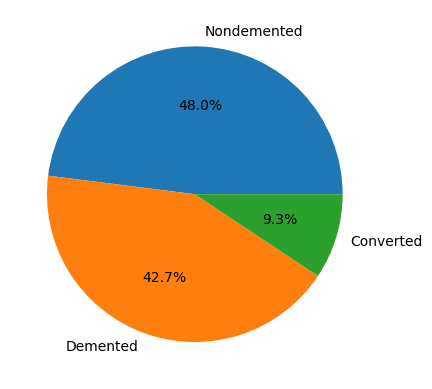

In [230]:
#sns.countplot(x='Group', data=data_u, order=data_u['Group'].value_counts().index)
plt.pie(data_u['group'].value_counts(), labels=data_u['group'].unique(), autopct='%1.1f%%')
plt.show()

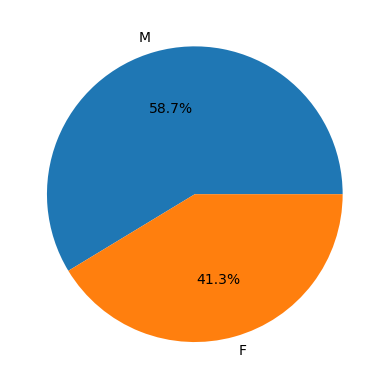

In [231]:
plt.pie(data_u['genre'].value_counts(), labels=data_u['genre'].unique(), autopct='%1.1f%%')
plt.show()

In [232]:
def age_range(age):
    if 60 <= age <= 65:
        return '60-65'
    elif 66 <= age <= 70:
        return '66-70'
    elif 71 <= age <= 80:
        return '71-80'
    elif 81 <= age <= 90:
        return '81-90'
    else:
        return '+90'

In [233]:
age_index = data_u.columns.get_loc('age')
data_u.insert(age_index + 1, 'age_range', data_u['age'].apply(age_range))

In [234]:
data_u

,subject_id,MRI_id,group,visit,MR_delay,genre,age,age_range,educ,SES,MMSE,CDR,eTIV,nWBV,ASF
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,88,81-90,14,2.0,30.0,0.0,2004,0.681,0.876
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,80,71-80,12,NaN,22.0,0.5,1698,0.701,1.034
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,90,81-90,18,3.0,27.0,0.0,1200,0.718,1.462
9,OAS2_0005,OAS2_0005_MR3,Nondemented,3,1603,M,85,81-90,12,4.0,30.0,0.0,1699,0.705,1.033
12,OAS2_0007,OAS2_0007_MR4,Demented,4,1281,M,75,71-80,16,NaN,27.0,1.0,1372,0.710,1.279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,OAS2_0182,OAS2_0182_MR2,Demented,2,776,M,75,71-80,12,NaN,20.0,0.5,1654,0.696,1.061
364,OAS2_0183,OAS2_0183_MR4,Nondemented,4,2107,F,72,71-80,13,2.0,30.0,0.0,1510,0.723,1.162
366,OAS2_0184,OAS2_0184_MR2,Demented,2,553,F,73,71-80,16,3.0,21.0,1.0,1351,0.708,1.299
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,86,81-90,16,1.0,26.0,0.5,1688,0.675,1.040


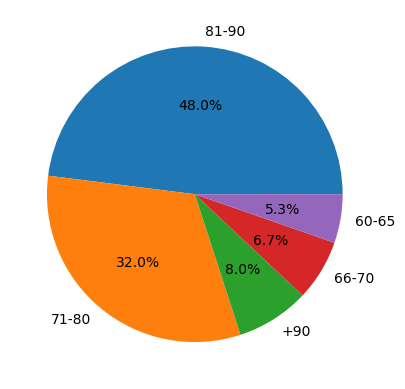

In [235]:
plt.pie(data_u['age_range'].value_counts(), labels=data_u['age_range'].unique(), autopct='%1.1f%%')
plt.show()

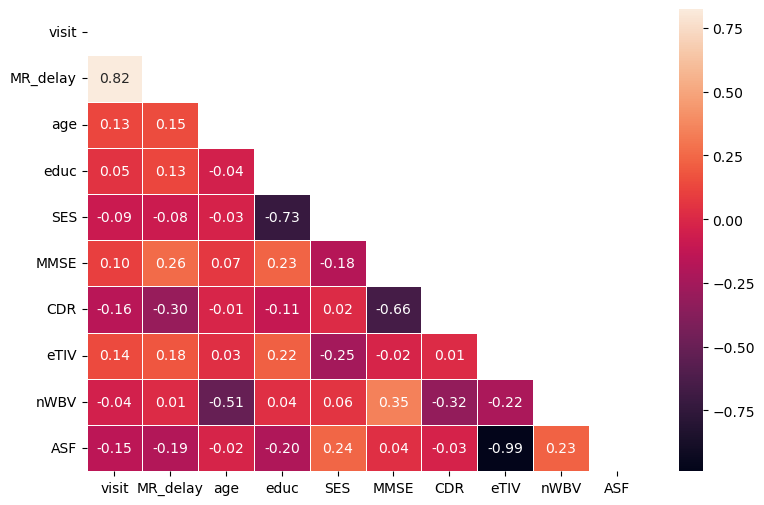

In [236]:
corr = data_u.select_dtypes(include=['int', 'float']).corr()
plt.figure(figsize=(9, 6))
sns.heatmap(corr, annot=True, fmt='.2f', linewidths=0.5, cmap='rocket', mask=np.triu(corr))
plt.show()

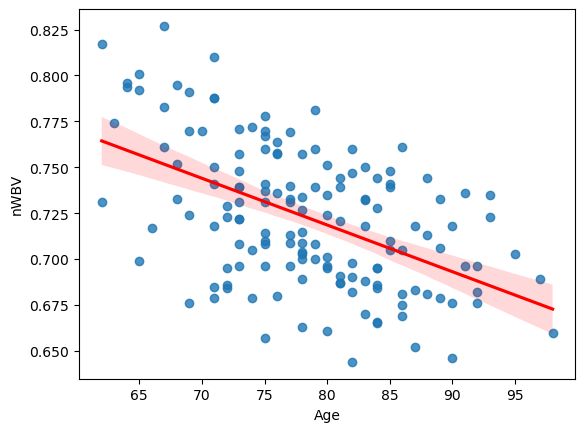

In [237]:
sns.regplot(x='age', y='nWBV', data=data_u, line_kws={'color' : 'red'})
plt.xlabel("Age")
plt.ylabel("nWBV")
plt.show()

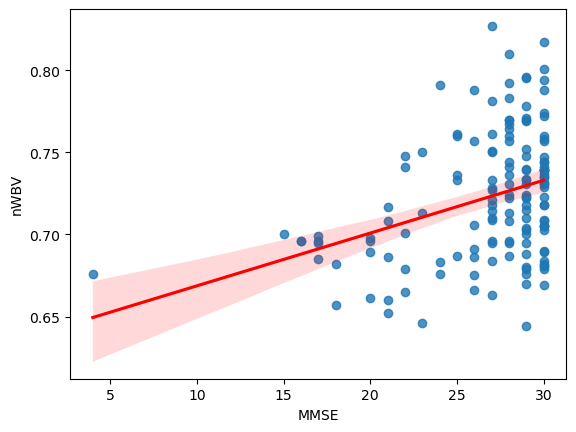

In [238]:
sns.regplot(x='MMSE', y='nWBV', data=data_u, line_kws={'color' : 'red'})
plt.xlabel("MMSE")
plt.ylabel("nWBV")
plt.show()